In [19]:
import json

import pooch
import pandas as pd
import xarray as xr

In [20]:
key = "qPwOeIrU-2501-PXXKVD-1011"
sdate = "19680101"
edate = "20241231"
url=f"https://www.nifs.go.kr/OpenAPI_json?id=sooList&key={key}&sdate={sdate}&edate={edate}"


In [21]:
fname_soo = pooch.retrieve(
    url=url,
    known_hash=None,
)


In [22]:
with open(fname_soo, "r", encoding="euc-kr") as file:
    raw_soo = json.load(file)

In [23]:
data_soo = pd.DataFrame(raw_soo["body"]["item"])

In [24]:
data_soo["obs_dtm"] = pd.to_datetime(data_soo["obs_dtm"])

In [25]:
data_soo.columns

Index(['nut_no3_n', 'sln_cde', 'lon', 'wtr_trn', 'wtr_tmp', 'nut_no2_n',
       'gru_nam', 'res_vsl_nm', 'nut_sio2_si', 'wtr_dep', 'dox', 'sta_cde',
       'qc_wtr', 'qc_sal', 'obs_dtm', 'sal', 'atm', 'nut_ph', 'qc_dox',
       'nut_po4_p', 'lat'],
      dtype='object')

In [26]:
# xarray Dataset 생성 함수
def dataframe_to_xarray(col):
    return xr.DataArray(
        data_soo[col],
        dims=["time"],
        coords={"time": data_soo["obs_dtm"],
                "x": ("time", data_soo["lon"]),
                "y": ("time", data_soo["lat"]),
                "z": ("time", data_soo["wtr_dep"])}
    )


In [27]:
# xarray Dataset 생성
data = xr.Dataset({col: dataframe_to_xarray(col) for col in data_soo.columns if col not in ["obs_dtm"]})


In [28]:
# 데이터 타입 변환
data_soo["lon"] = data_soo["lon"].astype(float)
data_soo["lat"] = data_soo["lat"].astype(float)
data_soo["wtr_dep"] = data_soo["wtr_dep"].astype(float)
data_soo["wtr_tmp"] = data_soo["wtr_tmp"].astype(float)


In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import csr_matrix
import numpy as np

In [30]:

# 데이터프레임의 모든 값을 숫자로 변환하고 NaN 값을 0으로 채움
numeric_data_soo = data_soo.apply(pd.to_numeric, errors='coerce').fillna(0)

# 희소 행렬로 변환
sparse_matrix = csr_matrix(numeric_data_soo.values)


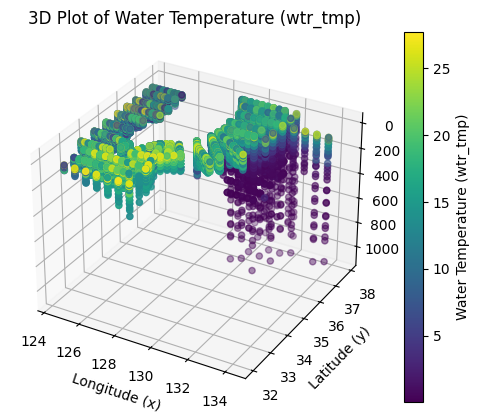

In [32]:
# 3D 산점도 플롯
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 데이터 추출
x = data_soo["lon"].values
y = data_soo["lat"].values
z = data_soo["wtr_dep"].values
wtr_tmp = data_soo["wtr_tmp"].values

# NaN 값을 제외한 데이터만 플롯
mask = ~np.isnan(wtr_tmp)
sc = ax.scatter(x[mask], y[mask], z[mask], c=wtr_tmp[mask], cmap='viridis')

# 컬러바 추가
plt.colorbar(sc, ax=ax, label='Water Temperature (wtr_tmp)')

# 축 레이블 설정
ax.set_xlabel('Longitude (x)')
ax.set_ylabel('Latitude (y)')
ax.set_zlabel('Water Depth (z)')

# z 축 뒤집기
ax.invert_zaxis()

# 플롯 제목 설정
ax.set_title('3D Plot of Water Temperature (wtr_tmp)')

# 플롯 표시
plt.show()